### Predicting House Pricing: A Regression Problem (Predicting a continious value instead of a discreate label).
Note: Logistic Regression is a classification algorithm

In [1]:
import numpy as np
from keras.datasets import boston_housing
from keras import models
from keras import layers

import matplotlib.pyplot as plt

C:\Users\sudip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 18us/step


#### Each feature in the input data has a different scale, some values are proportions (0 and 1), some may takes values between 1 and 12, others between 0 and 100, and so on.

In [5]:
print("Train Data: ",train_data.shape)
print("Test Data: ", test_data.shape)
print("Train Target:",train_targets.shape)

Train Data:  (404, 13)
Test Data:  (102, 13)
Train Target: (404,)


In [4]:
test_targets[1]

18.8

### Preparing the data
#### To deal with different scale for different features, need to do feature-wise normalization: For each feature substract the feature-mean and divide by the feature-standard_deviation. So that the feature is centered around 0 and has a unit standard deviation.

In [5]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
print(mean)
#print(std)

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]


In [6]:
train_data -= mean
train_data /= std

test_data -= mean # For test data also use same mean and std, because never use test data 
test_data /= std                                             #  in the workflow

In [7]:
train_data.mean(axis=0)

array([-1.01541438e-16,  1.09923072e-17,  1.74337992e-15, -1.26686340e-16,
       -5.25377321e-15,  6.41414864e-15,  2.98441140e-16,  4.94653823e-16,
        1.12671149e-17, -1.98136337e-16,  2.36686358e-14,  5.95679996e-15,
        6.13920356e-16])

In [8]:
train_data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Build the Network

In [9]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# Note: ###(Typical setup for scalar Regression).
        ### The network ends with a single unit and no activation.
    # With Activation ==> output restricted.

#### K-fold Validation
For small dataset, the validation scores might change a lot depending on which data points you chose to use for validation and which to chose for training.

K-fold cross-validation: Splitting the available data into K partitions, initializing K identical models, and training each one on K-1 partitions, while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.

In [10]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('# of fold:', i)
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], 
                                         train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], 
                                         train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

# of fold: 0
# of fold: 1
# of fold: 2
# of fold: 3


In [11]:
all_scores

[2.0562673157984666, 2.1780391305980116, 2.760687254443027, 2.3638041273202046]

In [12]:
np.mean(all_scores)

2.339699457039927

### Saving the Validation logs for each fold

In [13]:
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('# of fold:', i)
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], 
                                         train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], 
                                         train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

# of fold: 0
# of fold: 1
# of fold: 2
# of fold: 3


In [14]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [15]:
len(average_mae_history)

200

### Plotting Validation Scores

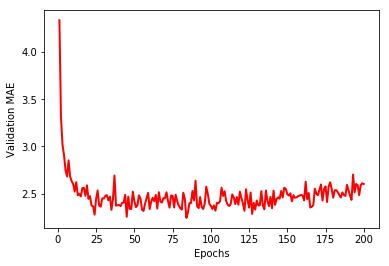

In [16]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history, color='red', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Excluding the first 10 data points and plotting validation scores

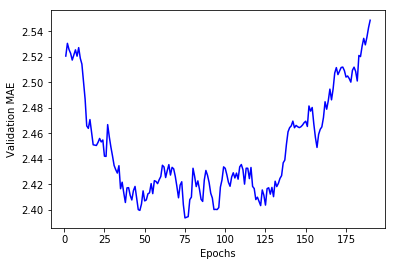

In [17]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### So, nearly after 25 epochs the validation MAE stops improving
### Training the final Model

In [18]:
model = build_model()
model.fit(train_data, train_targets, epochs=75, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print("Test MAE Score:", test_mae_score)

102/102 [==============================] - 0s 2ms/step
Test MAE Score: 2.515451384525673


### Note:
1. Each features must be scaled independentely.
1. Loss function (MSE), different from classification problem.
2. Evaluation metric for regression is Mean Absolute Error (MAE).
4. For smaller dataset, K-fold validation is extremely useful to evaluate the model.
5. For smaller dataset, use small network to avoid overfitting.